In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from scipy.integrate import odeint

In [352]:
from tqdm.notebook import tqdm

In [378]:
from scipy.integrate import solve_ivp

## Question 1

## Question 2

In [671]:
[1.62, 1.7,1.8, 2, 3]

[1.62, 1.7, 1.8, 2, 3]

In [709]:
I_e = 1.69 # ?nA
E = -70 # mV
R_m = 10 # Mega Ohm 
tau_m = 10 # ms
y_0 = E
V_th = -54 # mV
V_reset = -80 # mV


In [728]:
def get_firing_rate(I_e):
    total_time = 1000 # ms
    time_steps = np.linspace(0, total_time, total_time * 100 + 1) # creating timespace with dt=0.01 ms
    voltages = np.zeros_like(time_steps)
    currents = np.ones_like(time_steps) * I_e
    dt = 0.01 # ms
    
    spike_times = np.zeros_like(time_steps)
    voltages[0] = E
    for idx in range(len(time_steps) - 1):
        if voltages[idx] >= V_th:
            voltages[idx] = V_reset
            spike_times[idx] = 1
        
        V_inf = E + R_m * currents[idx]
        voltages[idx + 1] =  V_inf + (voltages[idx] - V_inf) * np.exp(-dt / tau_m)
            
    # print(f"Firing rate: {np.sum(spike_times)} Hz")
    voltages[spike_times == 1] = 40
    return np.sum(spike_times)

In [785]:
currents = [1.61, 1.62, 1.7,1.8, 2, 2.2, 2.4, 2.6, 2.8, 3]
firing_rates = [get_firing_rate(I_e) for I_e in currents]

In [786]:
def get_r_isi(I_e, R_m, E, V_reset, V_th):
    t_isi = tau_m * np.log((R_m * I_e + E - V_reset) / (R_m * I_e + E - V_th))
    return 1 / t_isi

In [787]:
firing_rates_isi = [get_r_isi(I_e, R_m, E, V_reset, V_th) for I_e in currents]

In [788]:
np.array(firing_rates_isi) * 1000

array([17.97100068, 20.51199026, 30.34130755, 37.89231817, 49.6301802 ,
       59.7379975 , 69.11236992, 78.06804415, 86.75438328, 95.2542318 ])

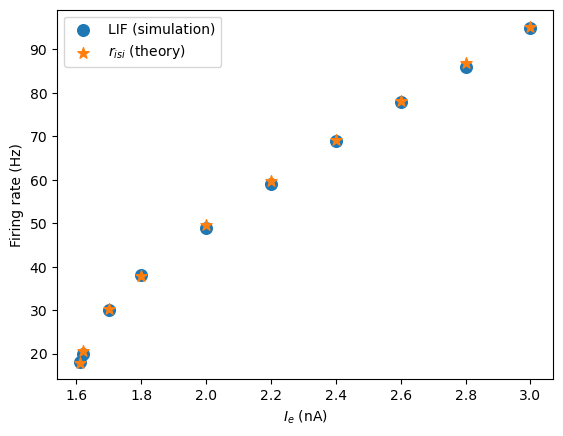

In [789]:
fig, axs = plt.subplots()
axs.scatter(currents, firing_rates, label='LIF (simulation)', s=70)
axs.scatter(currents, np.array(firing_rates_isi) * 1000, label='$r_{isi}$ (theory)', s=70, marker='*')
axs.set_xlabel('$I_{e}$ (nA)')
axs.set_ylabel('Firing rate (Hz)')
axs.legend()
plt.show()

[0.0000e+00 1.0000e-02 2.0000e-02 ... 4.9998e+02 4.9999e+02 5.0000e+02]


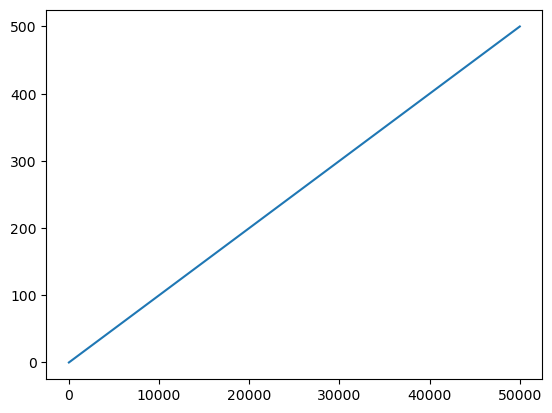

In [750]:
total_time = 500
arr = np.linspace(0, total_time, total_time * 100 + 1)
print(arr)
plt.plot(arr)
plt.show()

In [794]:
def plot_trace(I_e, R_m, V_th):
    total_time = 500 # ms
    time_steps = np.linspace(0, total_time, total_time * 100 + 1) # creating timespace with dt=0.01 ms
    voltages = np.zeros_like(time_steps)
    currents = np.zeros_like(time_steps)
    currents[10000:40000] = 1
    currents *= I_e
    dt = 0.01 # ms
    
    spike_times = np.zeros_like(time_steps)
    voltages[0] = E
    for idx in range(len(time_steps) - 1):
        if voltages[idx] >= V_th:
            voltages[idx] = V_reset
            spike_times[idx] = 1
        
        V_inf = E + R_m * currents[idx]
        voltages[idx + 1] =  V_inf + (voltages[idx] - V_inf) * np.exp(-dt / tau_m)
            
    voltages[spike_times == 1] = 40
    
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].plot(time_steps, currents)
    axs[0].set_ylabel('$I_{e}$ (nA)')
    axs[0].set_yticks([0, I_e])
    
    axs[1].plot(time_steps, voltages)
    axs[1].set_ylabel('V (mV)')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylim([-90, 50])
    plt.show()
    
    return voltages

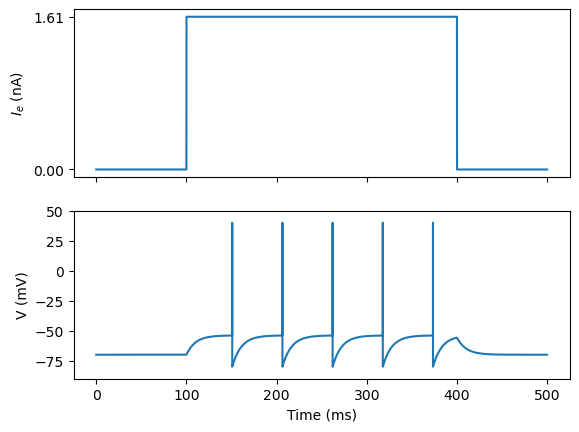

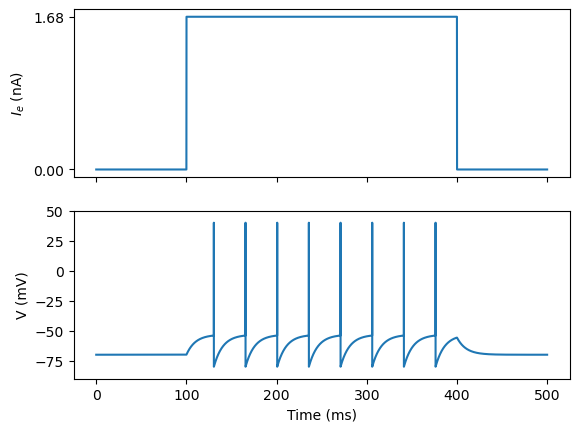

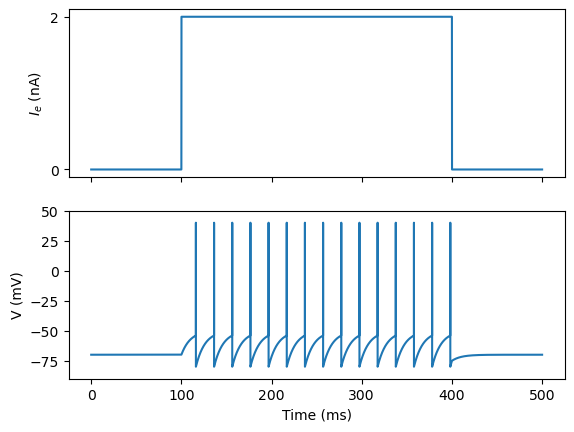

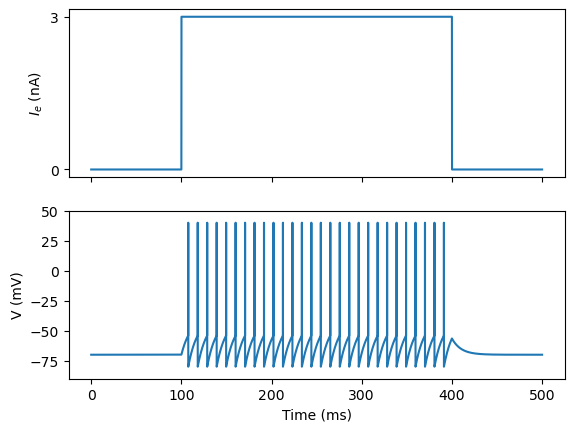

array([-70.        , -70.        , -70.        , ..., -69.99938476,
       -69.99938538, -69.99938599])

In [795]:
plot_trace(1.61, R_m, V_th)
plot_trace(1.68, R_m, V_th)
plot_trace(2, R_m, V_th)
plot_trace(3, R_m, V_th)

## Question 3

In [156]:
# persistent conductances
def alpha_n(V):
    """
    Opening rate of potassium gate
    """
    return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))

def beta_n(V):
    """
    Closing rate of Potassium gate
    """
    return 0.125 * np.exp(-0.0125 * (V + 65))


def tau_n(V):
    """
    time constant of potassium gate
    """
    return 1 / (alpha_n(V) + beta_n(V))


def n_infty(V):
    """
    ? asymptotic potassium activation
    """
    return alpha_n(V) / (alpha_n(V) + beta_n(V))


# transient conductances
def alpha_m(V):
    """
    opening rate of sodium gate
    """
    return (0.1 * (V + 40)) / (1 - np.exp(-0.1 * (V + 40)))

def beta_m(V):
    """
    closing rate of sodium gate
    """
    return 4 * np.exp(-0.0556 * (V + 65))


def m_infty(V):
    """
    ? asymptotic sodium activation
    """
    return alpha_m(V) / (alpha_m(V) + beta_m(V))


def tau_m(V):
    """
    ?time constant of sodium activation
    """
    return 1 / (alpha_m(V) + beta_m(V))


def alpha_h(V):
    """
    opening rate of ? sodium inactivation gate
    :return: 
    """
    return 0.07 * np.exp(-0.05 * (V + 65))


def beta_h(V):
    """
    closing rate of sodium inactivation gate
    """
    return 1 / (1 + np.exp(-0.1 * (V + 35)))


def tau_h(V):
    """
    ? time constant of sodium inactivation
    """
    return 1 / (alpha_h(V) + beta_h(V))


def h_infty(V):
    """
    ? asymptotic sodium inactivation
    """
    return alpha_h(V) / (alpha_h(V) + beta_h(V))


def i_m(V, n, m, h, g_L, g_K, g_Na, E_L, E_K, E_Na):
    """
    membrane current
    """
    i_m = g_L * (V - E_L) + g_K * n ** 4 * (V - E_K) + g_Na * m ** 3 * h * (V - E_Na)
    return i_m


# def HodgkinHuxley(y, t, I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na):
def HodgkinHuxley(t, y, I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na):
    """
    c_m: membrane capacitance  
    I: I_{e}/A
    :param y: 
    :param t: 
    :return: 
    """
    V, n, m, h = y
    
    dVdt = 1 / c_m * (-i_m(V, n, m, h, g_L, g_K, g_Na, E_L, E_K, E_Na) + I)
    
    dndt = (n_infty(V) - n) / tau_n(V)
    
    dmdt = (m_infty(V) - m) / tau_m(V)
    
    dhdt = (h_infty(V) - h) / tau_h(V)
    
    
    dydt = [
        dVdt, 
        dndt, 
        dmdt,
        dhdt
    ]
    return np.array(dydt)

In [142]:
c_m = 0.01 # microF / mm^2

V_init = -65 # mV
n_init = 0.3177
m_init = 0.0529
h_init = 0.5961

y_0 = [V_init, n_init, m_init, h_init] # initial conditions

# maximal conductances:
g_L = 0.003 # mS / mm^2
g_K = 0.36 # mS / mm^2
g_Na = 1.2 # mS / mm^2

# reversal potentials
E_L = -54.387 # mV
E_K = -77 # mV
E_Na = 50 # mV


In [143]:
t = np.arange(0, 200, 0.01)
I = 60 * 0.001

In [144]:
y_t = odeint(HodgkinHuxley, y_0, t, args=(I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na))

In [145]:
V = y_t[:, 0]

In [146]:
def plot_dynamics(y_t, t):
    V = y_t[:, 0]
    n = y_t[:, 1]
    m = y_t[:, 2]
    h = y_t[:, 3]
    
    fig, axs = plt.subplots(5, 1, sharex=True, figsize=(4, 8))
    axs[0].plot(t, V)
    axs[0].set_ylim([-80, 50])
    axs[0].set_ylabel('V (mV)')
    
    axs[1].plot(t, i_m(V, n, m, h, g_L, g_K, g_Na, E_L, E_K, E_Na))
    axs[1].set_ylim([-5, 5])
    axs[1].set_ylabel(r"$i_{m} ( \mu A / mm^{2})$")
    
    axs[2].plot(t, m)
    axs[2].set_ylim([0, 1])
    axs[2].set_ylabel(r"m")
    
    axs[3].plot(t, h)
    axs[3].set_ylim([0, 1])
    axs[3].set_ylabel(r"h")
    
    axs[4].plot(t, n)
    axs[4].set_ylim([0, 1])
    axs[4].set_ylabel(r"n")
    axs[4].set_xlabel(r"t (ms)")
    
    for ax in axs:
        ax.spines[['right', 'top']].set_visible(False)
    
    plt.show()

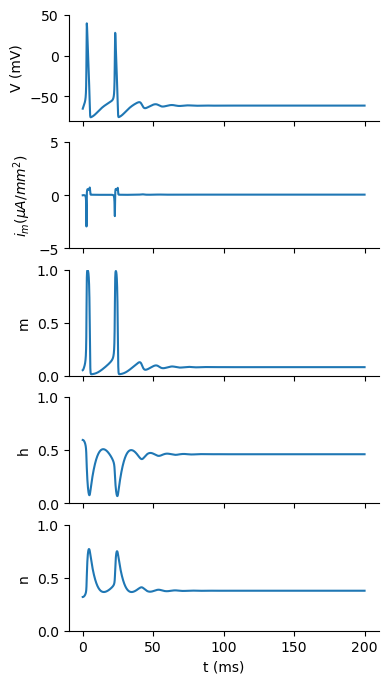

In [147]:
plot_dynamics(y_t, t)

# testing out equations for subgates

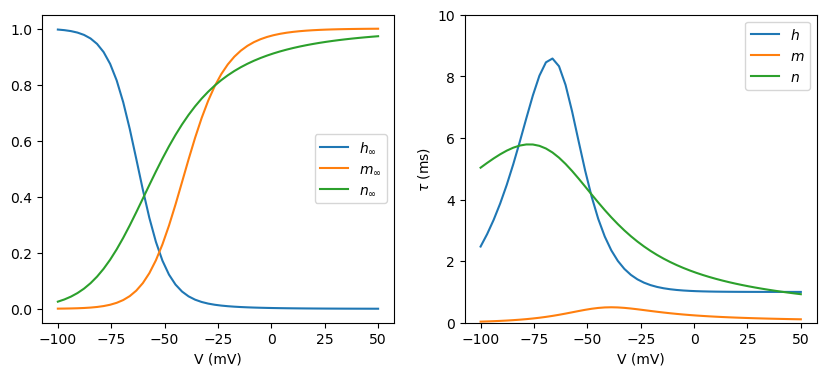

In [148]:
voltages = np.linspace(-100, 50)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(voltages, h_infty(voltages), label='$h_{\infty}$')
axs[0].plot(voltages, m_infty(voltages), label='$m_{\infty}$')
axs[0].plot(voltages, n_infty(voltages), label='$n_{\infty}$')
axs[0].set_xlabel('V (mV)')
axs[0].legend()

axs[1].plot(voltages, tau_h(voltages), label='$h$')
axs[1].plot(voltages, tau_m(voltages), label='$m$')
axs[1].plot(voltages, tau_n(voltages), label='$n$')
axs[1].set_xlabel('V (mV)')
axs[1].set_ylabel(r'$\tau$ (ms)')
axs[1].set_ylim([0, 10])
axs[1].legend()
plt.show()

## Tasks

## a)

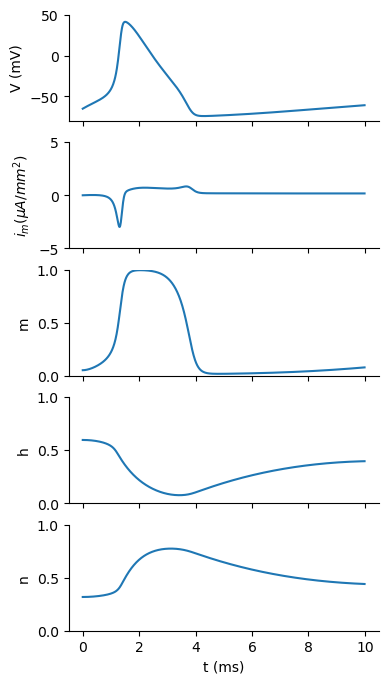

In [149]:
t = np.arange(0, 10, 0.01)
I = 200 * 0.001
y_t = odeint(HodgkinHuxley, y_0, t, args=(I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na))

plot_dynamics(y_t, t)

In [150]:
from scipy.integrate import solve_ivp

In [165]:
sol = solve_ivp(HodgkinHuxley, t_span = [0, 10], y0=y_0, t_eval=np.arange(0, 10.01, 0.01), args=(I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na), method='RK45')

/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:6: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:12: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-0.0125 * (V + 65))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  dndt = (n_infty(V) - n) / tau_n(V)
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:34: RuntimeWarning: overflow encountered in exp
  return (0.1 * (V + 40)) / (1 - np.exp(-0.1 * (V + 40)))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:40: RuntimeWarning: overflow encountered in exp
  return 4 * np.exp(-0.0556 * (V + 65))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:109: RuntimeWarning: divide by zero enco

In [166]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-02 ...  9.990e+00  1.000e+01]
        y: [[-6.500e+01 -6.480e+01 ... -6.077e+01 -6.074e+01]
            [ 3.177e-01  3.177e-01 ...  4.400e-01  4.398e-01]
            [ 5.290e-02  5.293e-02 ...  7.934e-02  7.957e-02]
            [ 5.961e-01  5.961e-01 ...  3.961e-01  3.962e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 338
     njev: 0
      nlu: 0

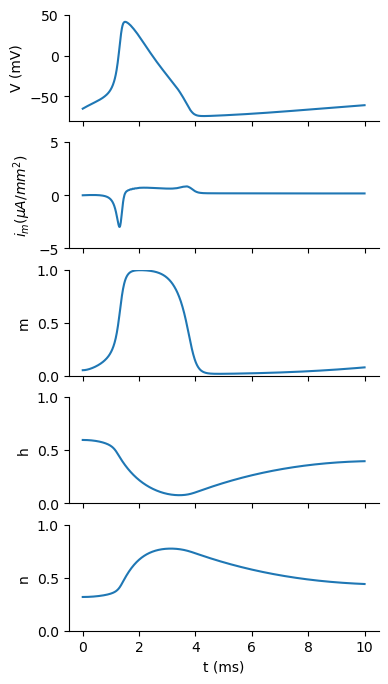

In [167]:
plot_dynamics(sol.y.T, sol.t)

## b)

In [315]:
np.linspace(0, 1000, 100001, retstep=True)

(array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 9.9998e+02, 9.9999e+02,
        1.0000e+03]),
 0.01)

In [345]:
I = 80 * 0.001
sol = solve_ivp(HodgkinHuxley, t_span = [0, 1000], y0=y_0, t_eval=np.linspace(0, 1000, 100001), args=(I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na), method='RK45')

/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:6: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:12: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-0.0125 * (V + 65))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  dndt = (n_infty(V) - n) / tau_n(V)
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:34: RuntimeWarning: overflow encountered in exp
  return (0.1 * (V + 40)) / (1 - np.exp(-0.1 * (V + 40)))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:40: RuntimeWarning: overflow encountered in exp
  return 4 * np.exp(-0.0556 * (V + 65))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:109: RuntimeWarning: divide by zero enco

In [346]:
V_th = -50 # mV

In [347]:
np.logical_and(sol.y[0, :-1] < V_th, sol.y[0, 1:] > V_th).sum()

63

In [348]:
def compute_firing_rate(I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na):
    # count the number of spikes emitted in one second
    sol = solve_ivp(HodgkinHuxley, t_span = [0, 1000], y0=y_0, t_eval=np.linspace(0, 1000, 100001), args=(I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na), method='RK45')
    return np.logical_and(sol.y[0, :-1] < V_th, sol.y[0, 1:] > V_th).sum() # Hz
    


In [350]:
np.arange(501)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [357]:
currents = np.arange(501)
firing_rates = np.zeros_like(currents)
for idx, I in tqdm(enumerate(currents)):
    firing_rates[idx] = compute_firing_rate(I * 0.001, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na)

0it [00:00, ?it/s]

/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:6: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:12: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-0.0125 * (V + 65))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  dndt = (n_infty(V) - n) / tau_n(V)
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:34: RuntimeWarning: overflow encountered in exp
  return (0.1 * (V + 40)) / (1 - np.exp(-0.1 * (V + 40)))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:40: RuntimeWarning: overflow encountered in exp
  return 4 * np.exp(-0.0556 * (V + 65))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:109: RuntimeWarning: divide by zero enco

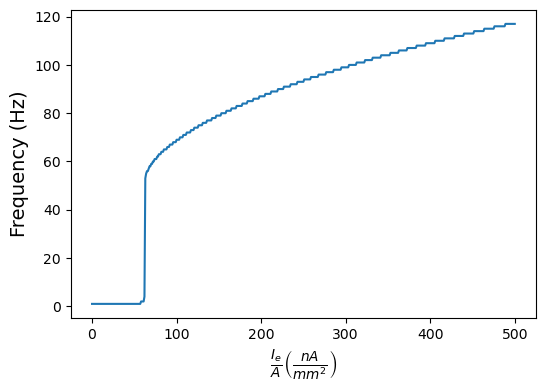

In [376]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(currents, firing_rates)
ax.set_xlabel(r"$\frac{I_e}{A} \left(\frac{nA}{mm^2}\right)$", fontsize=14)
ax.set_ylabel('Frequency (Hz)', fontsize=14)
plt.show()

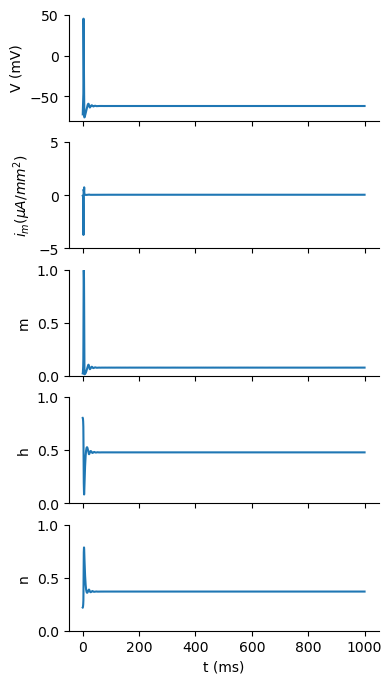

In [329]:
plot_dynamics(sol.y.T, sol.t)

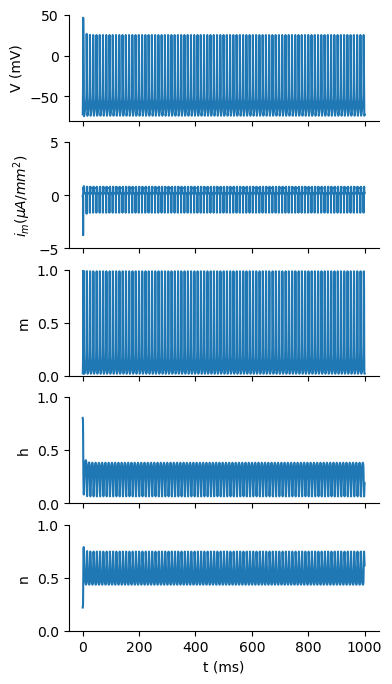

In [318]:
plot_dynamics(sol.y.T, sol.t)

|## c)

In [304]:
I = -50 * 0.001
solution_part_I = solve_ivp(HodgkinHuxley, t_span = [0, 5], y0=y_0, t_eval=np.linspace(0, 5, 501), args=(I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na), method='RK45')

In [305]:
solution_part_I

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-02 ...  4.990e+00  5.000e+00]
        y: [[-7.197e+01 -7.197e+01 ... -7.197e+01 -7.197e+01]
            [ 2.182e-01  2.182e-01 ...  2.182e-01  2.182e-01]
            [ 2.264e-02  2.264e-02 ...  2.261e-02  2.261e-02]
            [ 8.033e-01  8.033e-01 ...  8.036e-01  8.036e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 68
     njev: 0
      nlu: 0

In [307]:
y_0 = solution_part_I.y[:, -1] # we continue from the output of the previous simulation
I = 0.
solution_part_II = solve_ivp(HodgkinHuxley, t_span = [0, 15], y0=y_0, t_eval=np.linspace(0, 15, 1501), args=(I, c_m, g_L, g_K, g_Na, E_L, E_K, E_Na), method='RK45')


/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:6: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:12: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-0.0125 * (V + 65))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  dndt = (n_infty(V) - n) / tau_n(V)
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:34: RuntimeWarning: overflow encountered in exp
  return (0.1 * (V + 40)) / (1 - np.exp(-0.1 * (V + 40)))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:40: RuntimeWarning: overflow encountered in exp
  return 4 * np.exp(-0.0556 * (V + 65))
/var/folders/n1/flc1py3s4bxbl8xglyb2sxqc0000gn/T/ipykernel_27886/719927879.py:109: RuntimeWarning: divide by zero enco

In [309]:
y_t = np.concatenate((solution_part_I.y, solution_part_II.y[:, 1:]), axis=1)

In [310]:
y_t.shape

(4, 2001)

In [312]:
np.linspace(0, 20, 2001, retstep=True)

(array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.998e+01, 1.999e+01,
        2.000e+01]),
 0.01)

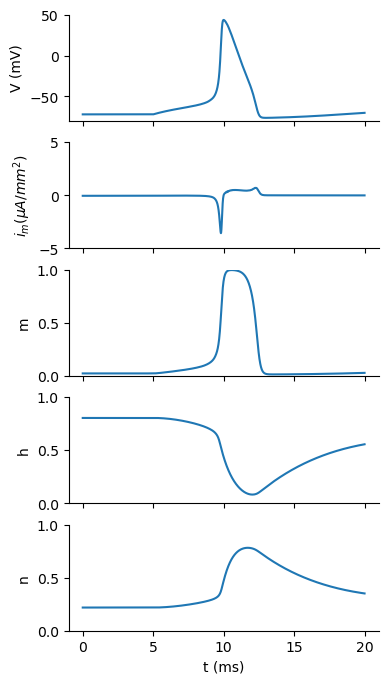

In [313]:
plot_dynamics(y_t.T, np.linspace(0, 20, 2001))